In [1]:
!pip install pandas scikit-learn nltk

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
import string

# завантаження стоп-слів
nltk.download('stopwords')
stop_words = stopwords.words('english')  # заміни на 'russian' або 'ukrainian' якщо потрібно

# 1. Завантаження датасету
df = pd.read_csv("hate-speech-and-offensive-language.csv")

# 2. Попередня обробка
def preprocess(text):
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['tweet'].apply(preprocess)

# 3. Векторизація
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])
y = df['class']  # 0 = не мова ворожнечі, 1 = мова ворожнечі

# 4. Розділення на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Навчання моделі
model = LogisticRegression()
model.fit(X_train, y_train)

# 6. Оцінка
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 7. Перевірка нового тексту
def check_hate(text):
    cleaned = preprocess(text)
    vector = vectorizer.transform([cleaned])
    pred = model.predict(vector)[0]
    if pred == 1:
        # приклад простої логіки для визначення законодавства
        if any(word in cleaned for word in ['nation', 'race', 'religion']):
            law = "Може порушувати ст. 161 ККУ"
        else:
            law = "Мова ворожнечі, але закон не визначено"
    else:
        law = "ОК, не ворожнеча"
    return pred, law

# Тест
text = "These people ruin our country"
result, law = check_hate(text)
print(f"Результат: {'Мова ворожнечі' if result else 'Немає'}, Закон: {law}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


              precision    recall  f1-score   support

           0       0.53      0.12      0.19       290
           1       0.90      0.97      0.93      3832
           2       0.84      0.76      0.80       835

    accuracy                           0.88      4957
   macro avg       0.75      0.62      0.64      4957
weighted avg       0.87      0.88      0.87      4957

Результат: Мова ворожнечі, Закон: Мова ворожнечі, але закон не визначено


In [3]:
print(df.columns)

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')


In [8]:
import random

# Список ключових слів, які можуть свідчити про порушення закону (упрощено)
us_hate_keywords = ['kill', 'nazi', 'jew', 'lynch', 'burn', 'go back', 'exterminate', 'white power', 'hate']

def check_us_law_violation(text):
    text_lower = text.lower()
    if any(word in text_lower for word in us_hate_keywords):
        return "Possible violation of U.S. hate speech laws (e.g., 18 U.S. Code § 249)"
    return "No clear legal violation detected"

# 1. Випадковий набір твітів
sample_df = df.sample(10)

# 2. Виводимо кожен твіт і результат
for idx, row in sample_df.iterrows():
    tweet = row['tweet']
    pred_class = model.predict(vectorizer.transform([preprocess(tweet)]))[0]
    
    label = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}.get(pred_class, "Unknown")
    law_status = check_us_law_violation(tweet)
    
    print("📣 Tweet:")
    print(tweet)
    print("➡️ Prediction:", label)
    print("⚖️ Legal Check:", law_status)
    print("-" * 60)


📣 Tweet:
That bad bitches get left because of wack pussy kinda overrated cause the sex can get better if everything about her is cool
➡️ Prediction: Offensive Language
⚖️ Legal Check: No clear legal violation detected
------------------------------------------------------------
📣 Tweet:
RT @Kaedashian: &#8220;@WhitDAWGem_: There is nothing wrong with Ariana Grande..... Just cause she don't look like hoe.... Y'all gotta a problem.&#8230;
➡️ Prediction: Offensive Language
⚖️ Legal Check: No clear legal violation detected
------------------------------------------------------------
📣 Tweet:
RT @RhineRunIt: Henny &amp; hoes. RT @TiFFANY_P0RSCHE: Peace &amp; tranquillity &#8220;@daddykn0wsbest: If you were a Greek Mythical God&#8230;what would u be &#8230;
➡️ Prediction: Offensive Language
⚖️ Legal Check: No clear legal violation detected
------------------------------------------------------------
📣 Tweet:
@saucygyro niggers fell off
➡️ Prediction: Offensive Language
⚖️ Legal Check: No cle

In [1]:
!pip install streamlit

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import joblib
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Завантаження ---
df = pd.read_csv("hate-speech-and-offensive-language.csv")  # або original файл

# --- Препроцесинг ---
def preprocess(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['cleaned'] = df['tweet'].apply(preprocess)

# --- Розбиття ---
X = df['cleaned']
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Векторизація ---
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# --- Модель з урахуванням класів ---
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_vec, y_train)

# --- Оцінка ---
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# --- Збереження ---
joblib.dump(model, "model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


              precision    recall  f1-score   support

           0       0.30      0.61      0.40       290
           1       0.97      0.85      0.90      3832
           2       0.76      0.93      0.83       835

    accuracy                           0.85      4957
   macro avg       0.67      0.79      0.71      4957
weighted avg       0.90      0.85      0.86      4957



['vectorizer.pkl']

<Axes: xlabel='class'>

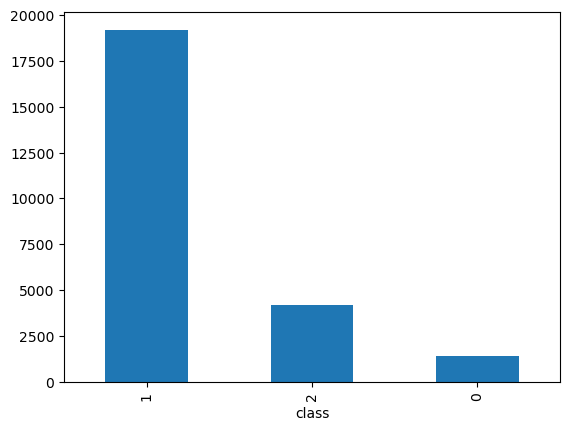

In [8]:
import matplotlib.pyplot as plt
df['class'].value_counts().plot(kind='bar')


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import joblib
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Завантаження ---
df = pd.read_csv("hate-speech-and-offensive-language.csv")

# --- Препроцесинг ---
def preprocess(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['cleaned'] = df['tweet'].apply(preprocess)

# --- Undersampling для класу 1 ---
class_counts = df['class'].value_counts()
min_class_size = class_counts.min()

# Перебирання кожного класу для підрізання
df_balanced = pd.concat([
    df[df['class'] == 0].sample(min_class_size, random_state=42),
    df[df['class'] == 1].sample(min_class_size, random_state=42),
    df[df['class'] == 2].sample(min_class_size, random_state=42)
])

# Перемішуємо набір даних
df_balanced = shuffle(df_balanced, random_state=42)

# --- Розбиття ---
X = df_balanced['cleaned']
y = df_balanced['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Векторизація ---
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# --- Модель з урахуванням класів ---
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_vec, y_train)

# --- Оцінка ---
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# --- Збереження ---
joblib.dump(model, "model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


              precision    recall  f1-score   support

           0       0.80      0.67      0.73       268
           1       0.81      0.81      0.81       294
           2       0.83      0.94      0.88       296

    accuracy                           0.81       858
   macro avg       0.81      0.81      0.80       858
weighted avg       0.81      0.81      0.81       858



['vectorizer.pkl']

In [1]:
!pip install googletrans


   -------------------- ------------------- 2/4 [h2]
   ------------------------------ --------- 3/4 [googletrans]
   ---------------------------------------- 4/4 [googletrans]



In [2]:
!pip install wordcloud

In [1]:
!pip install joblib